<a href="https://colab.research.google.com/github/FireStrings/MasterDegree/blob/main/EDA/EDA_Geral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definitions
- Definir estações
- Artigo para ler: https://latamt.ieeer9.org/index.php/transactions/article/view/5563
- Plotar hora a hora, e o describe
- Transformação logaritmica, para variacia não constante?
- Método Box-Cox ou deflacionar a série
- Modelar a serie temporal
  - Normality hypothesis tests, Anderson-Darling and Shapiro-Wilk
  - Decompor em 3 partes: tendência, sazonalidade e resíduo
- Aplicar estacionariedade
- Verificar precipitação, quando tiver.
- A press atmo do nivel da estacao ja é a media
- Usar temp. Bulbo seco
- Agrupar por estacoes do ano (verao, inverno, etc)
- Corte as 5h as 21h
- Verificar umidade no litoral
- Pegar estacoes proximas, ir do litoral ao interior
- Pegar principalmente duas regioes (bahia e sul, por exemplo)
- Transfer learning entre estacoes nas regioes


### Escolhendo estações
  - Dados de Curitiba (A807), Z1
  - Dados de Pelotas (A887), Z2
  - Dados de Belo Horizonte pampulha (A521), Z3
  - Dados de Brasilia (A001), Z4
  - Dados de Governador Valadares (A532), Z5
  - Dados de Campo Grande (A702), Z6
  - Dados de Mossoró (A318), Z7,
  - Dados de Manaus (A101), Z8


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

import os
os.chdir("/content/drive/My Drive/UFSCAR/Notebooks")

Mounted at /content/drive/


### Imports

In [ ]:
%run UtilsNew.ipynb

In [ ]:
l_datasets = ["brasilia",
              "curitiba",
              "manaus",
              "campo_grande",
              "minas_gerais_bh",
              "minas_gerais_gv",
              "pelotas",
              "teresina"]

l_raw_data = []

for i in l_datasets:
    l_raw_data.append(load_files(i, False))

### Informações dos datasets

In [ ]:
dict_result = {}
for i, j in zip(l_raw_data, l_datasets):
    buffer = io.StringIO()
    i["Radiacao (KJ/m²)"].info(buf=buffer)
    s = buffer.getvalue()
    total = s.split("\n")[1].split(": ")[1].split(" ")[0]
    non_null = s.split("\n")[5].split(" ")[0]
    dict_result[j] = [int(total), int(non_null)]

df_nulls = pd.DataFrame.from_dict(dict_result, orient='index')

df_nulls["Percentual de registros não nulos"] = df_nulls[1]/df_nulls[0]
df_nulls = df_nulls.reset_index().rename(columns={"index":"estacao"})

<Axes: xlabel='estacao', ylabel='Percentual de registros não nulos'>

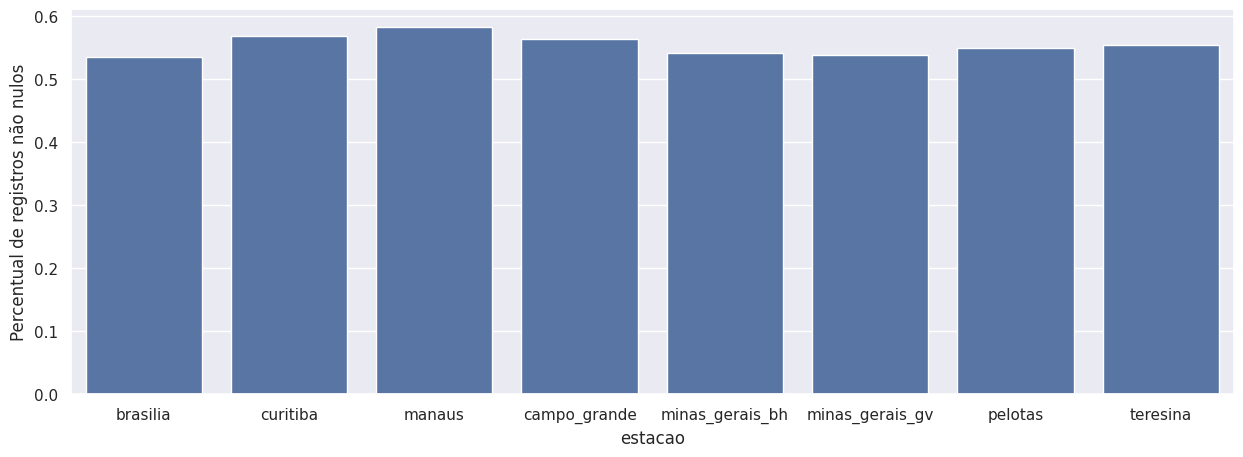

In [ ]:
set_size_plot(15, 5)
sns.barplot(df_nulls[["estacao", "Percentual de registros não nulos"]], x="estacao", y="Percentual de registros não nulos")

In [ ]:
df_nulls[["estacao", "Percentual de registros não nulos"]]

,estacao,Percentual de registros não nulos
0,brasilia,0.534086
1,curitiba,0.568000
2,manaus,0.581680
3,campo_grande,0.562585
4,minas_gerais_bh,0.540299
5,minas_gerais_gv,0.537563
6,pelotas,0.549647
7,teresina,0.553751


### Pre processamento

In [ ]:
dict_processed = {}
for i, j in zip(l_raw_data, l_datasets):
    dict_processed[j] = pre_processing(i)

### Remoção de horários

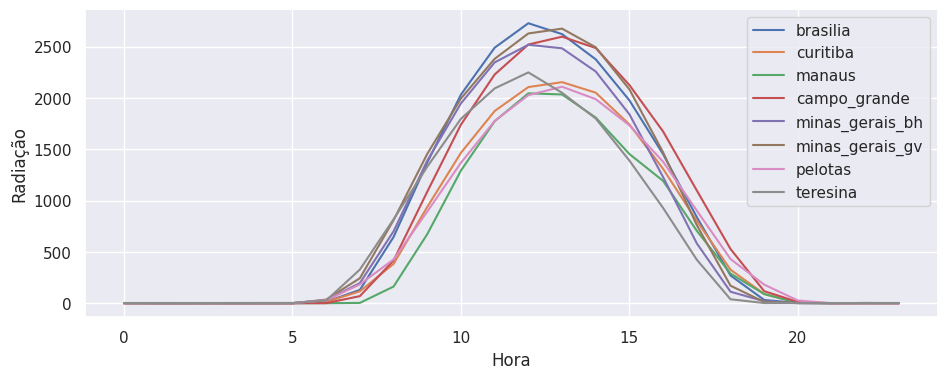

In [ ]:
set_plot_size(11, 4)

plt.ylabel('Radiação')
plt.xlabel('Hora')
for i in dict_processed.keys():
    df_hour_mean = dict_processed[i][["hora", "radiacao"]].groupby(['hora'])\
    ['radiacao'].agg(['mean']).reset_index().rename(columns={"mean":i})
    sns.lineplot(data=df_hour_mean, x='hora', y=i, label=i)


### Algumas estatisticas

In [ ]:
numeric_cols = ['float16', 'float32', 'float64']

lista_df_estacoes = []

for i in dict_processed.keys():
    l_df_stats = []

    local_df = dict_processed[i]
    local_df["data_hora_teste"] = pd.to_datetime(local_df["data_hora"])

    outono, inverno, primavera, verao = filter_seasons(local_df, "data_hora_teste")

    lista_estacoes = [outono, inverno, primavera, verao]
    lista_estacoes_str = ["outono", "inverno", "primavera", "verao"]
    for j, k in zip(lista_estacoes, lista_estacoes_str):
        series = j\
        .select_dtypes(include=numeric_cols)\
        .describe()[["radiacao", "temp_ins_c"]].T[["mean", "std"]].T["radiacao"]

        l_df_stats.append(pd.DataFrame([series]).T.rename(columns={"radiacao":k}).T)

    result_df = pd.concat(l_df_stats).reset_index().rename(columns={"index":"season"})
    result_df["estacao"] = i
    result_df.set_index(["estacao", "season"], inplace=True)
    lista_df_estacoes.append(result_df)

pd.concat(lista_df_estacoes)

mean          std
estacao         season                             
brasilia        outono     1461.884989  1028.363155
                inverno    1557.993029  1032.690440
                primavera  1462.279377  1188.650878
                verao      1352.673770  1092.409298
curitiba        outono     1142.765550  1047.789132
                inverno     973.173637   897.779959
                primavera  1049.399053  1041.648094
                verao      1204.210881  1087.425113
manaus          outono      827.474569   852.363341
                inverno    1063.788871   984.113159
                primavera  1078.946225   997.096953
                verao       949.985771   985.373635
campo_grande    outono     1258.721159  1014.347895
                inverno    1309.752240   997.958576
                primavera  1455.350873  1182.800610
                verao      1565.544498  1214.565561
minas_gerais_bh outono     1330.775281   974.397466
                inverno    1337.642404   957.612563
                primavera  1425.246896  1155.309876
                verao      1287.952381  1070.341795
minas_gerais_gv outono     1386.705946  1031.861520
                inverno    1383.301304  1018.477567
                primavera  1479.553843  1208.135668
                verao      1458.523991  1254.157790
pelotas         outono      871.090614   816.542697
                inverno     822.502551   822.300942
                primavera  1307.773236  1180.862412
                verao      1520.823691  1191.047934
teresina        outono      779.636600   841.908586
                inverno    1276.209018   846.899968
                primavera  1309.707815   909.574635
                verao      1020.685317   835.329692

from matplotlib import pyplot as plt
_df_0['mean'].plot(kind='hist', bins=20, title='mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['std'].plot(kind='hist', bins=20, title='std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='mean', y='std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['std'].plot(kind='line', figsize=(8, 4), title='std')
plt.gca().spines[['top', 'right']].set_visible(False)

### Correlação

In [ ]:
corr = dict_processed["teresina"].select_dtypes(include=numeric_cols).corr()

<Axes: >

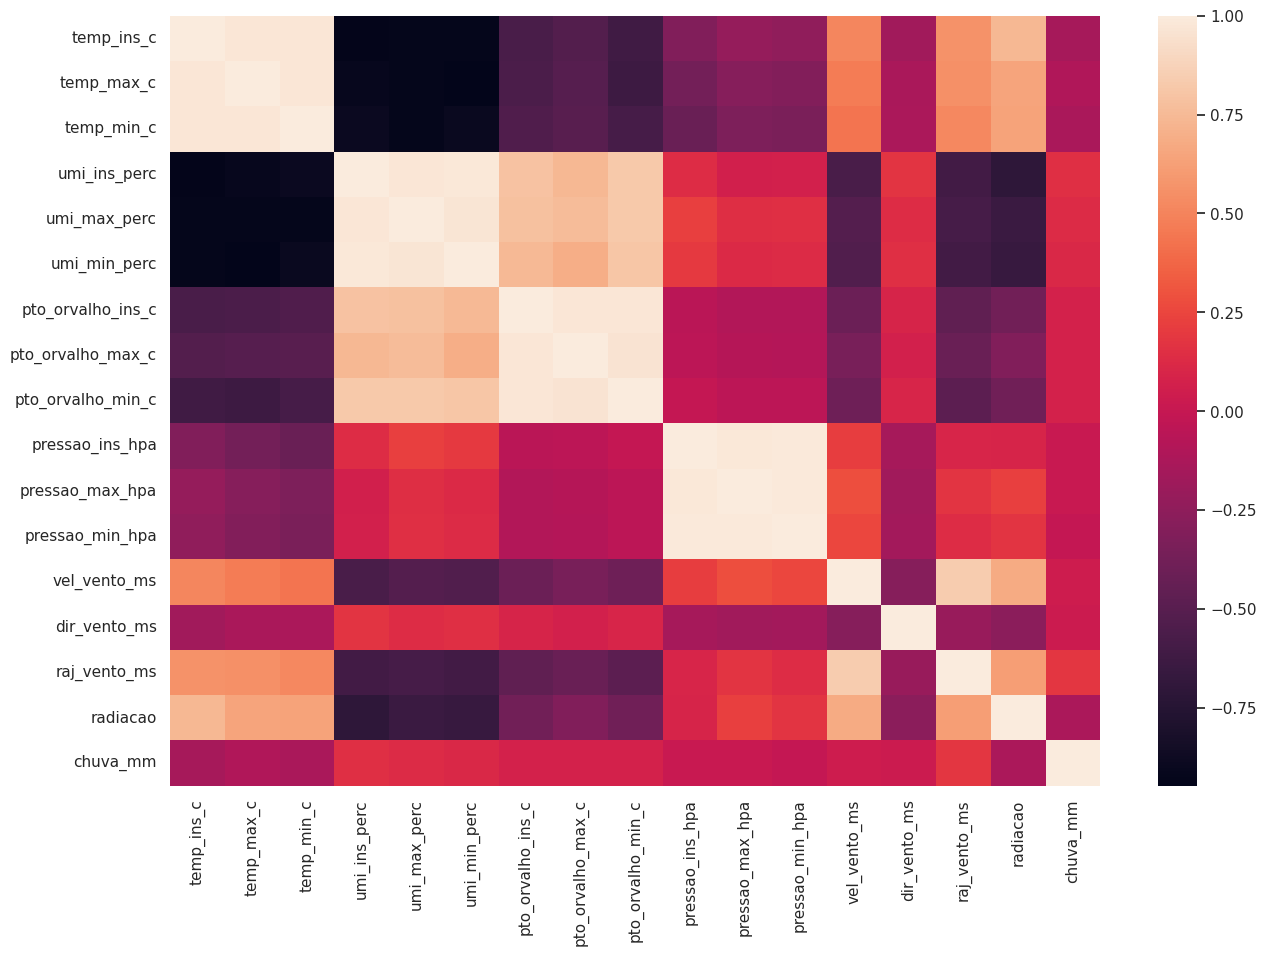

In [ ]:
set_plot_size(15, 10)
sns.heatmap(corr)

In [ ]:
dict_processed["teresina"]\
.select_dtypes(include=numeric_cols)\
[["umi_ins_perc", "temp_ins_c", "radiacao", "vel_vento_ms"]]\
.corr()

,umi_ins_perc,temp_ins_c,radiacao,vel_vento_ms
umi_ins_perc,1.000000,-0.933359,-0.709988,-0.570517
temp_ins_c,-0.933359,1.000000,0.734898,0.512483
radiacao,-0.709988,0.734898,1.000000,0.674900
vel_vento_ms,-0.570517,0.512483,0.674900,1.000000


### Serie temporal

In [ ]:
dict_processed.keys()

dict_keys(['brasilia', 'curitiba', 'manaus', 'campo_grande', 'minas_gerais_bh', 'minas_gerais_gv', 'pelotas', 'teresina'])

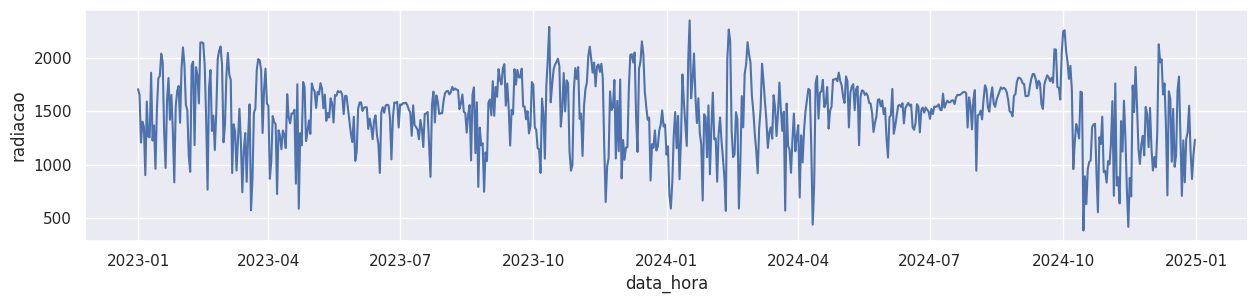

In [ ]:
set_plot_size(15, 3)

series_brasilia = dict_processed["brasilia"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_brasilia.resample("D").mean(), x="data_hora", y="radiacao")


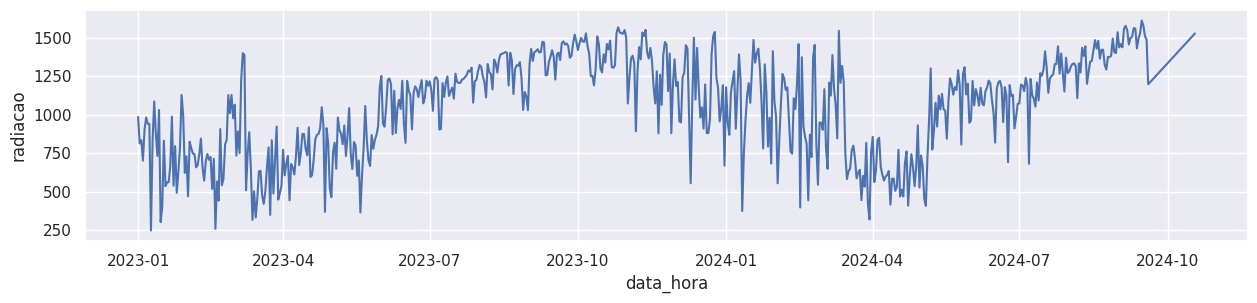

In [ ]:
series_teresina = dict_processed["teresina"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_teresina.resample("D").mean(), x="data_hora", y="radiacao")

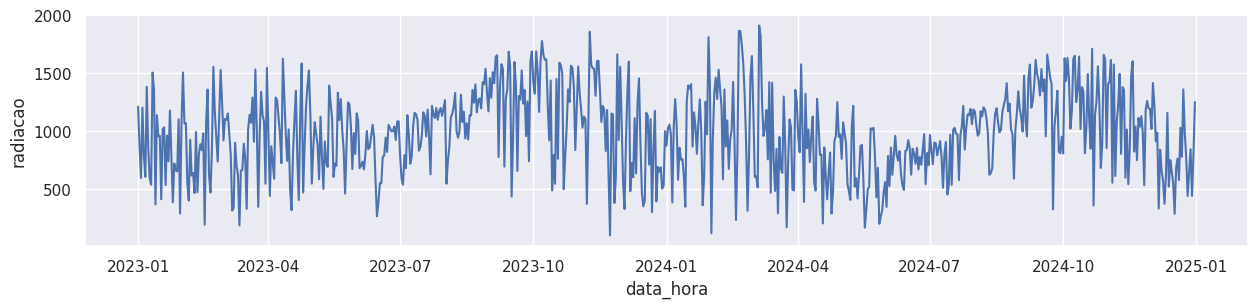

In [ ]:
series_manaus = dict_processed["manaus"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_manaus.resample("D").mean(), x="data_hora", y="radiacao")

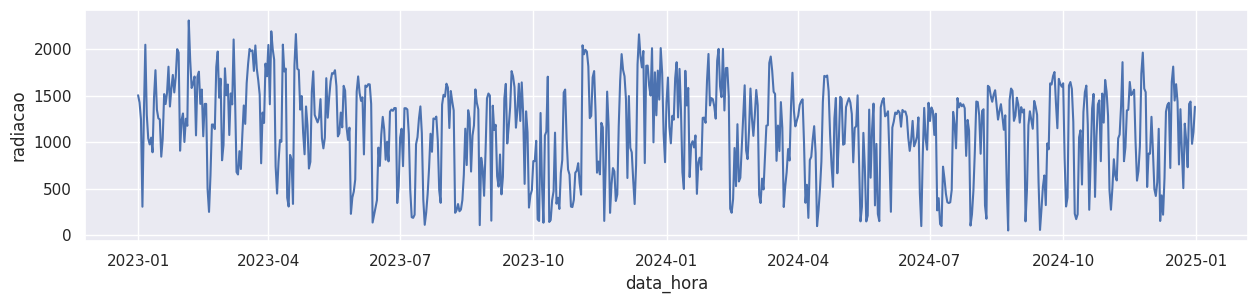

In [ ]:
series_ctb = dict_processed["curitiba"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_ctb.resample("D").mean(), x="data_hora", y="radiacao")

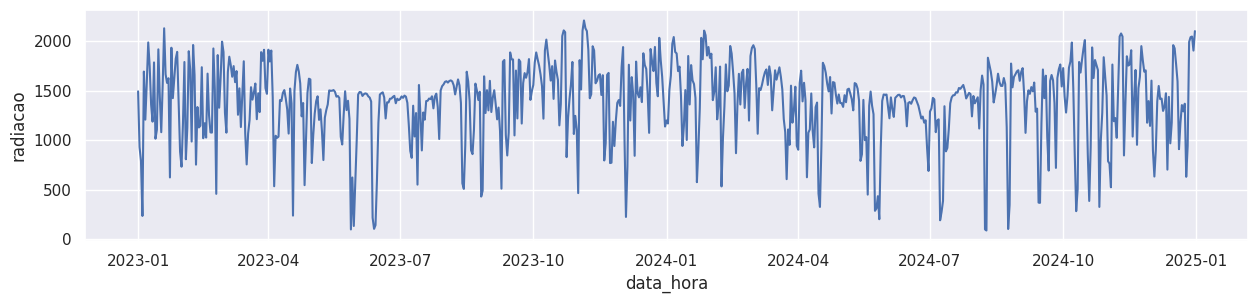

In [ ]:
series_campo_grande = dict_processed["campo_grande"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_campo_grande.resample("D").mean(), x="data_hora", y="radiacao")

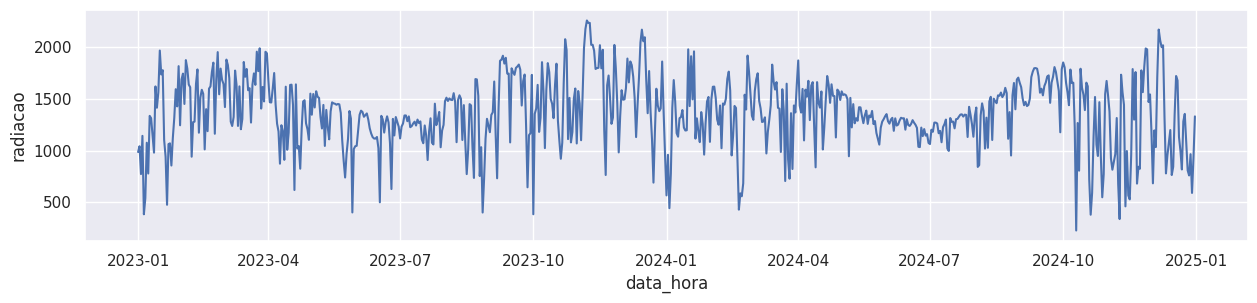

In [ ]:
series_bh = dict_processed["minas_gerais_bh"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_bh.resample("D").mean(), x="data_hora", y="radiacao")

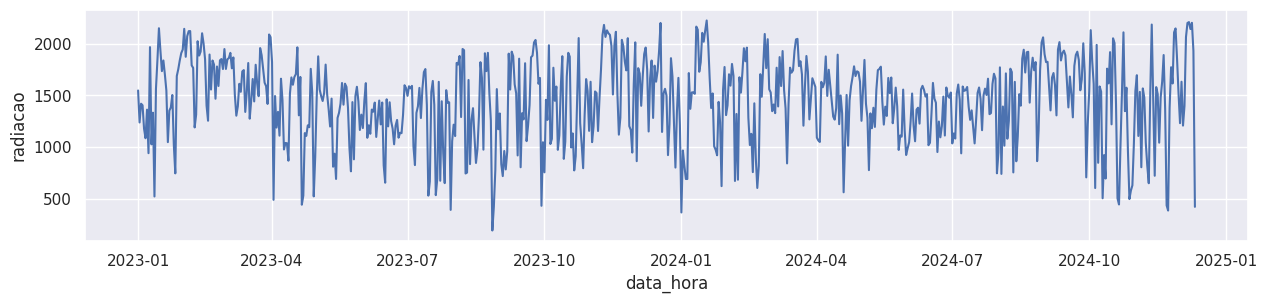

In [ ]:
series_gv = dict_processed["minas_gerais_gv"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_gv.resample("D").mean(), x="data_hora", y="radiacao")

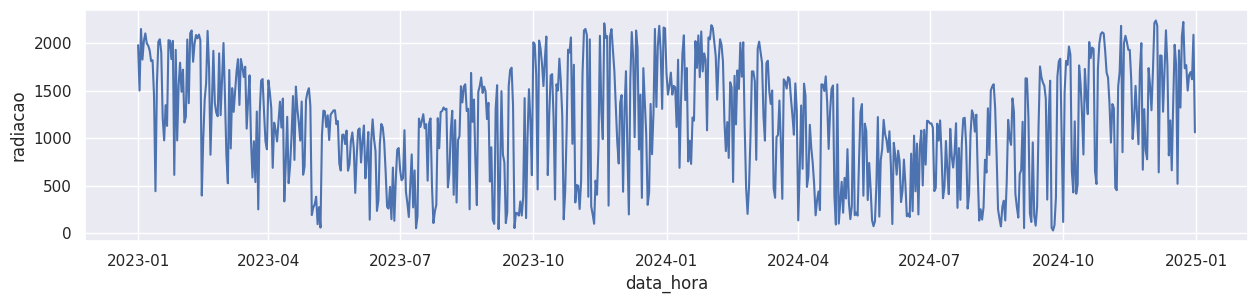

In [ ]:
series_pelotas = dict_processed["pelotas"][["radiacao", "data_hora"]].set_index("data_hora")
plot = sns.lineplot(data=series_pelotas.resample("D").mean(), x="data_hora", y="radiacao")

### Estacionariedade AdFuler

In [ ]:
import statsmodels.tsa.stattools as ts

def adfuller_test(df):
    result=ts.adfuller(df)
    labels = ['Teste estatístico ADF','p-valor','Num Lags','Numero de observações']
    for value, label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.")
    else:
        print("Fracas evidências contra a hipotese nula(Ho), a série temporal possui uma raíz unitária, indicando que é não estacionária.")

In [ ]:
adfuller_test(series_brasilia["radiacao"])

Teste estatístico ADF : -11.312603260574928
p-valor : 1.22847461983887e-20
Num Lags : 36
Numero de observações : 9333
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [ ]:
adfuller_test(series_teresina["radiacao"])

Teste estatístico ADF : -7.468861132817824
p-valor : 5.117824983746419e-11
Num Lags : 29
Numero de observações : 9685
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [ ]:
adfuller_test(series_manaus["radiacao"])

Teste estatístico ADF : -11.869729029533303
p-valor : 6.54668631702354e-22
Num Lags : 38
Numero de observações : 10166
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [ ]:
adfuller_test(series_ctb["radiacao"])

Teste estatístico ADF : -10.74672357494209
p-valor : 2.7298366039172857e-19
Num Lags : 23
Numero de observações : 4972
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [ ]:
adfuller_test(series_campo_grande["radiacao"])

Teste estatístico ADF : -9.596917632516014
p-valor : 1.9670885538209985e-16
Num Lags : 29
Numero de observações : 4912
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [ ]:
adfuller_test(series_bh["radiacao"])

Teste estatístico ADF : -7.399036002904435
p-valor : 7.641344526228884e-11
Num Lags : 31
Numero de observações : 4713
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [ ]:
adfuller_test(series_gv["radiacao"])

Teste estatístico ADF : -8.251285126788588
p-valor : 5.382402394560683e-13
Num Lags : 30
Numero de observações : 4547
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


In [ ]:
adfuller_test(series_pelotas["radiacao"])

Teste estatístico ADF : -6.853382838870461
p-valor : 1.6720857181748553e-09
Num Lags : 28
Numero de observações : 4805
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


### Teste de media movel

<Axes: >

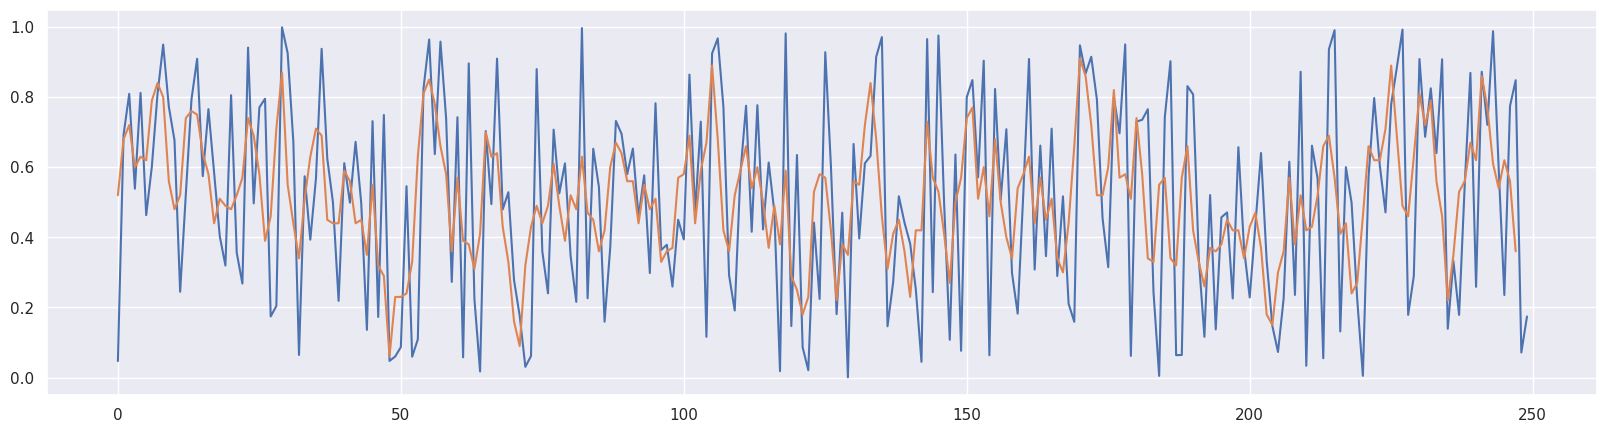

In [ ]:
import numpy as np

arr = []

for i in range(0, 250):
    rng2 = np.random.default_rng()
    arr.append(rng2.random())

window_size = 3

i = 0
moving_averages = []

while i < len(arr) - window_size + 1:

	window = arr[i : i + window_size]

	window_average = round(sum(window) / window_size, 2)

	moving_averages.append(window_average)

	i += 1

set_plot_size(20, 5)
sns.lineplot(arr)
sns.lineplot(moving_averages)

### Media movel

<Axes: xlabel='data_hora', ylabel='radiacao'>

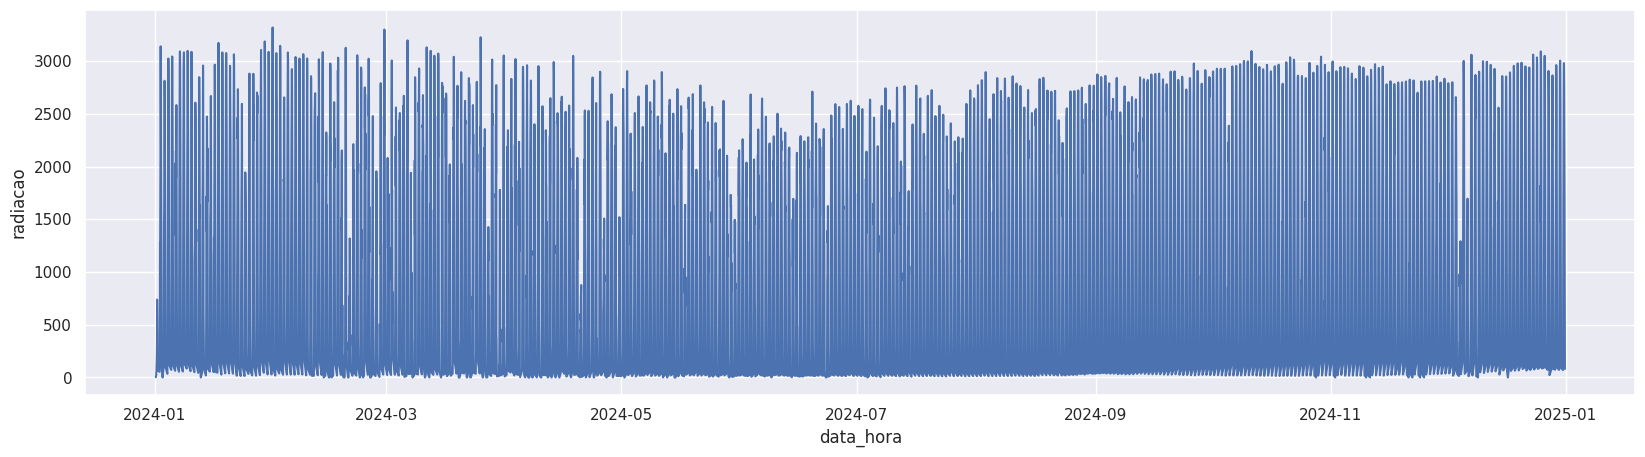

In [ ]:
sns.lineplot(data=dict_processed["mossoro"], x="data_hora", y="radiacao")

<Axes: xlabel='data_hora', ylabel='media_movel'>

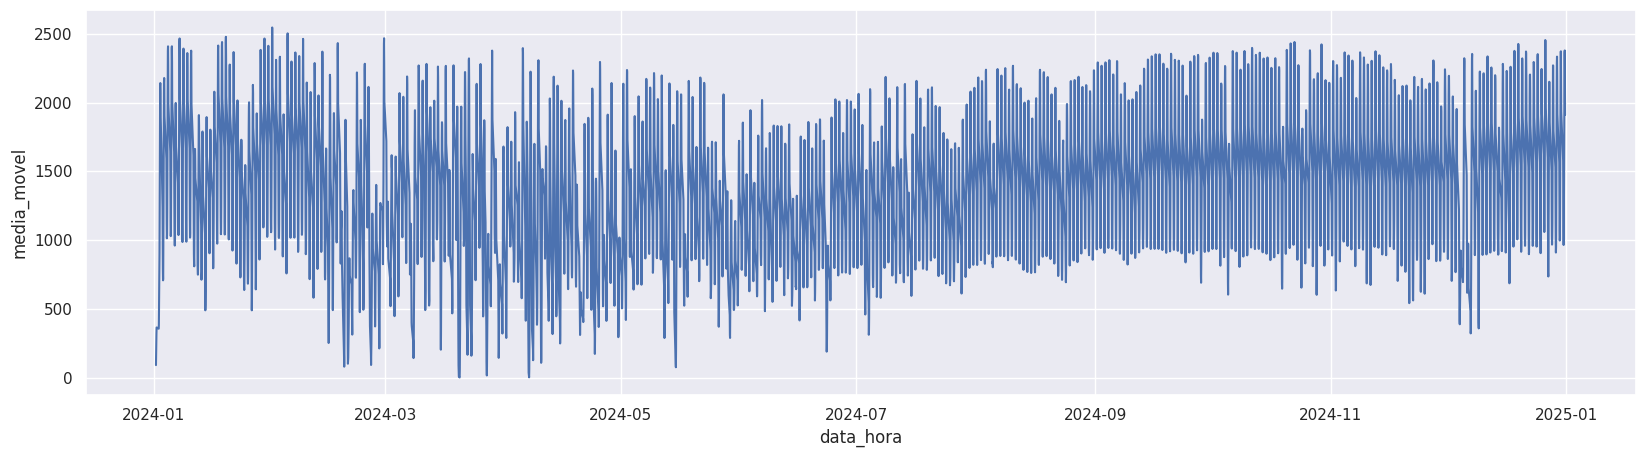

In [ ]:
df_test = dict_processed["mossoro"]
df_test["media_movel"] = df_test.radiacao.rolling(8).mean()
sns.lineplot(data=df_test, x="data_hora", y="media_movel")

In [ ]:
df_test[["data_hora", "radiacao", "media_movel"]].head(10)

,data_hora,radiacao,media_movel
data_hora,,,
2024-01-01 09:00:00,2024-01-01 06:00:00-03:00,2.5,NaN
2024-01-01 10:00:00,2024-01-01 07:00:00-03:00,9.3,NaN
2024-01-01 11:00:00,2024-01-01 08:00:00-03:00,17.6,NaN
2024-01-01 12:00:00,2024-01-01 09:00:00-03:00,37.6,NaN
2024-01-01 13:00:00,2024-01-01 10:00:00-03:00,68.0,NaN
2024-01-01 14:00:00,2024-01-01 11:00:00-03:00,121.7,NaN
2024-01-01 15:00:00,2024-01-01 12:00:00-03:00,195.2,NaN
2024-01-01 16:00:00,2024-01-01 13:00:00-03:00,305.6,94.6875
2024-01-01 17:00:00,2024-01-01 14:00:00-03:00,738.8,186.7250


### Aumento e aceleração

<Axes: xlabel='data', ylabel='aumento'>

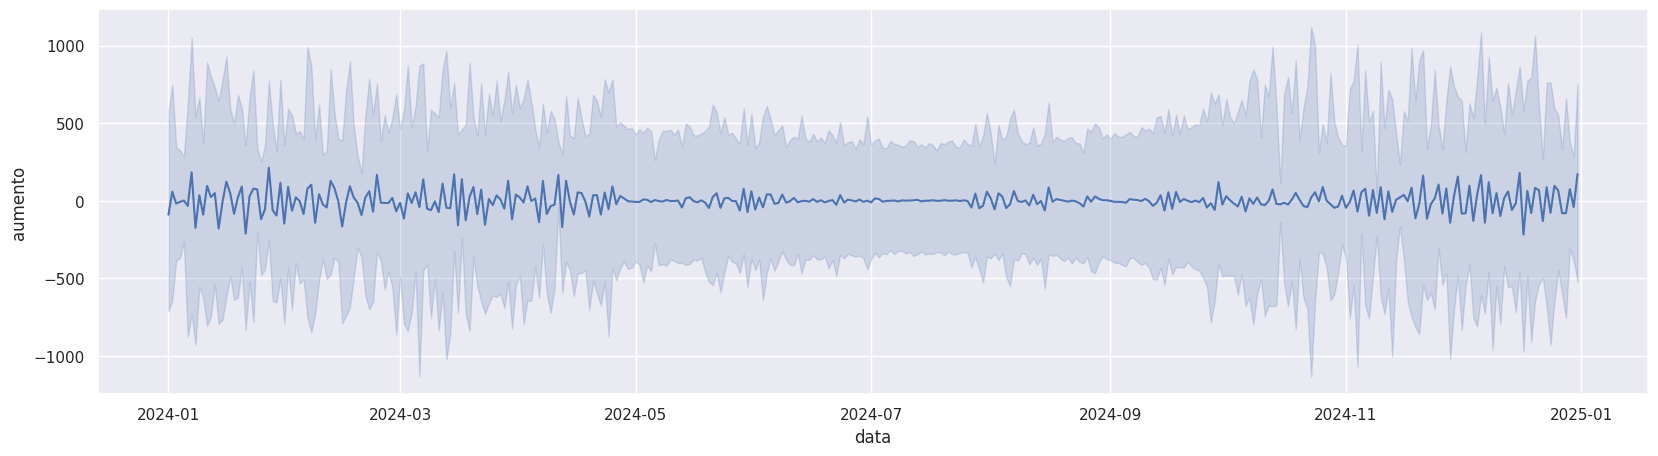

In [ ]:
df_test = filter_between(df, "hora", 10, 17)
df_test['aumento'] = df_test.radiacao.diff()
sns.lineplot(data=df_test, x="data", y="aumento")

<Axes: xlabel='data', ylabel='aceleracao'>

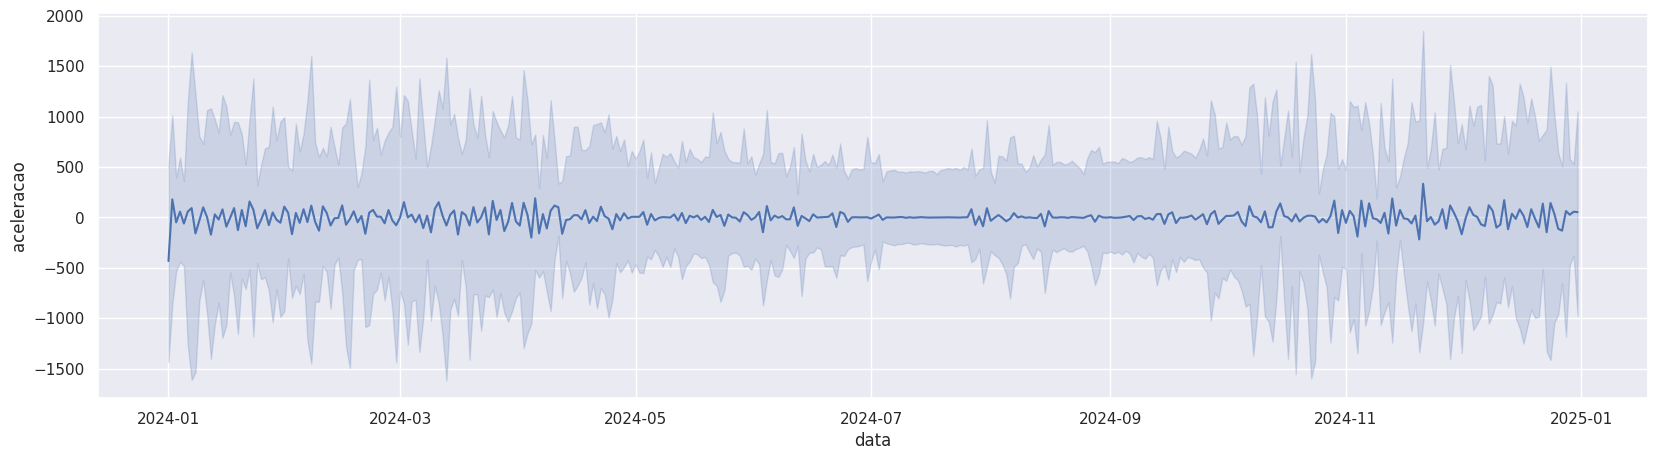

In [ ]:
df_test['aceleracao'] = df_test.aumento.diff()
sns.lineplot(data=df_test, x="data", y="aceleracao")

### Autocorrelação

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4699 entries, 2024-01-01 09:00:00 to 2024-12-31 22:00:00
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype                            
---  ------             --------------  -----                            
 0   data               4699 non-null   object                           
 1   temp_ins_c         4699 non-null   float64                          
 2   temp_max_c         4699 non-null   float64                          
 3   temp_min_c         4699 non-null   float64                          
 4   umi_ins_perc       4699 non-null   float64                          
 5   umi_max_perc       4699 non-null   float64                          
 6   umi_min_perc       4698 non-null   float64                          
 7   pto_orvalho_ins_c  4699 non-null   float64                          
 8   pto_orvalho_max_c  4699 non-null   float64                          
 9   pto_orvalho_min_c  4699 non-null   flo

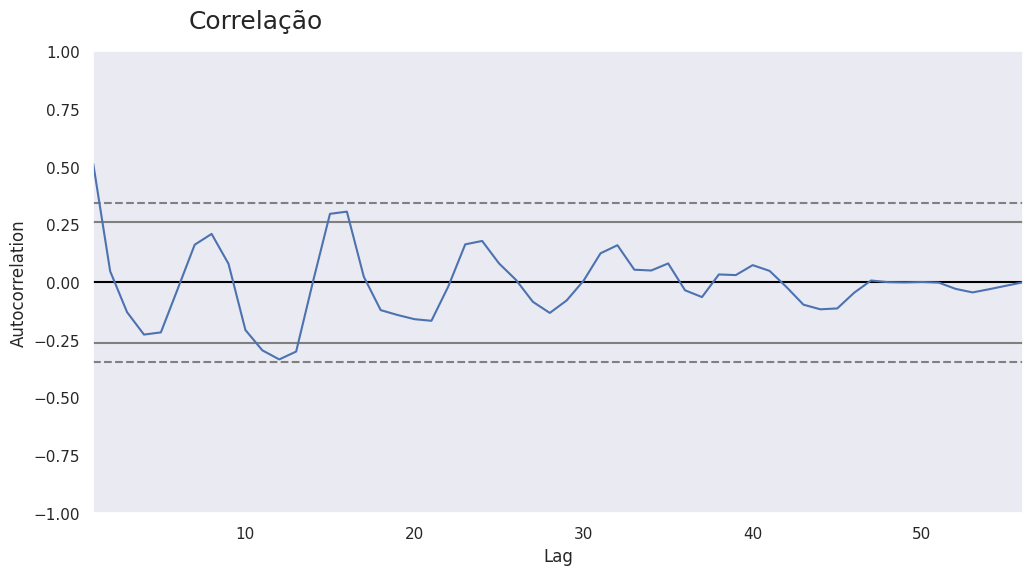

In [ ]:
df_test = filter_between(df, "hora", 10, 17)
df_test = filter_between(df_test, "data_hora", "2024-03-21", "2024-03-28")
ax = plt.figure(figsize=(12,6))
ax.suptitle("Correlação", fontsize=18, x=0.26, y=0.95)
autocorrelation_plot(df_test.radiacao)
ax=ax

### Decomposição

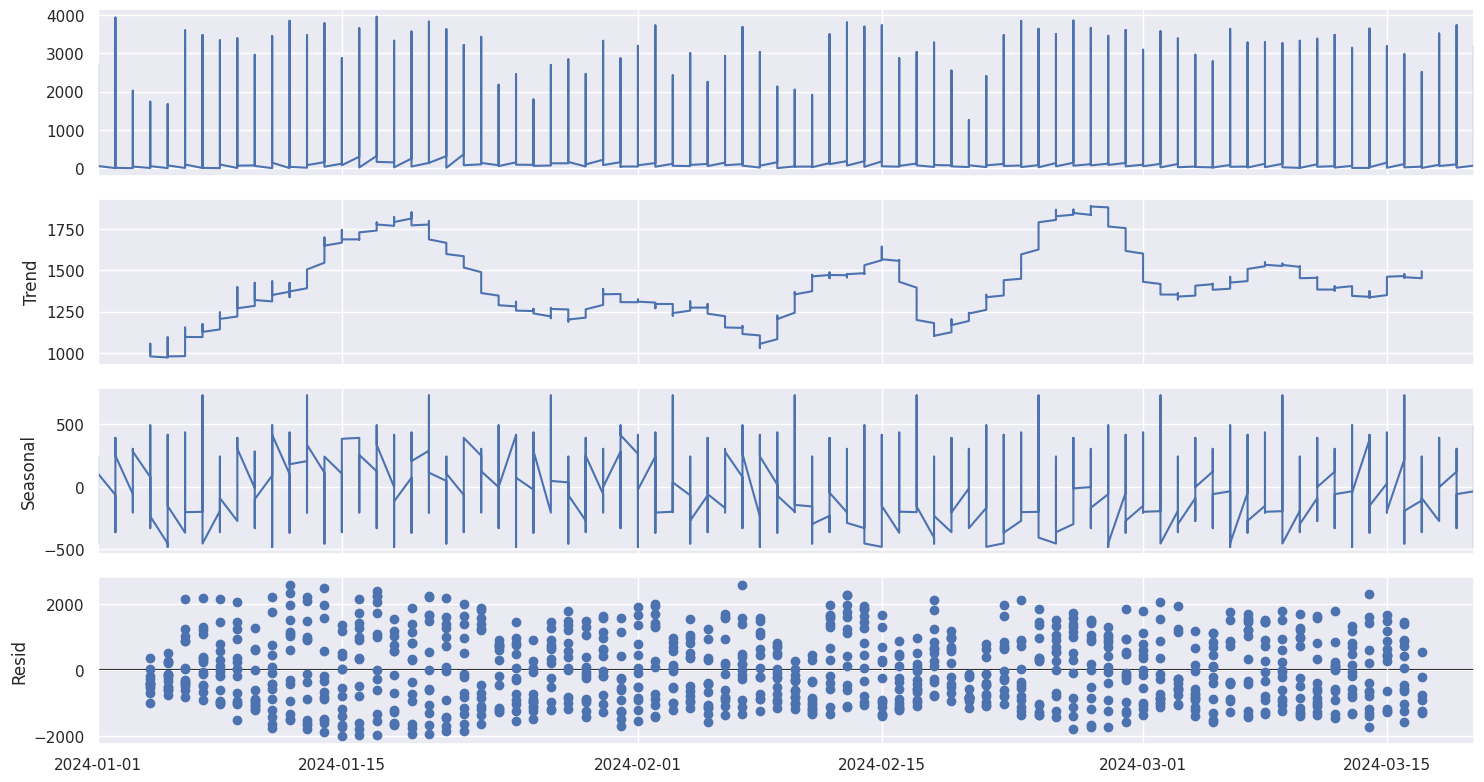

In [ ]:
set_plot_size(15, 8)
df_test = filter_between(df, "hora", 6, 21)
df_test = filter_between(df_test, "data_hora", "2024-01-01", "2024-03-21")

resultado = seasonal_decompose(df_test[["radiacao", "data"]].set_index('data'), period=90)
ax = resultado.plot()

### Box-Cox

In [ ]:
# Importar bibliotecas
from scipy.stats import boxcox
# Calcular melhor valor de lambda para a série temporal
df_box_cox = filter_between(df, "data", "2023-01-01", "2023-03-21")
df_box_cox = filter_between(df_box_cox, "hora", 10, 17)
serie_temporal2, lambda_boxcox = boxcox(df_box_cox["radiacao"])

In [ ]:
df_box_cox["rad"] = serie_temporal2

In [ ]:
set_plot_size(11, 5)
sns.lineplot(data=df_box_cox, x="data", y="rad")